In [1]:
# Show plots inline, and load main getdist plot module and samples class
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pylab as mplot
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True



%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.figsize'] = (16.,8.)
#import config

from chainconsumer import ChainConsumer


GetDist Version: 1.3.4, Matplotlib version: 3.1.1


In [2]:
def get_names(filename):
    """
    Function to obtain the names of the parameters of your chain
    """
    data = np.genfromtxt(filename, names=True)
    names = np.array(data.dtype.names)
    #print(names)
    #print(len(names))
    return names

def get_indices(filename, list_vars):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    return indices

def get_om_s8(filename):
    # might be useful later..
    data = np.loadtxt(filename)
    nsample = get_nsample(filename)
    data_params = []
    data_params.append([data[-nsample:,0], data[-nsample:,-3]*(data[-nsample:,0]/0.3)**(0.5)])
    data_params = np.array(data_params[0][:]).T
    weights = data[-nsample:,-1]
    return data_params, weights

def compute_s8(om, sigma_8):
    return sigma_8*(om/0.3)**0.5

In [8]:
dir = '../../data_vectors/cosmodc2/2022/star_sample/Sep14/chains/'
dir2 = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/'
nlbins = 5

burnin = 150000
kde = 2.

name_plots = 'cosmodc2-lcdm'

chainfile_0 = dir + 'cosmodc2_3x2pt_fourier_lcdm.txt'
name_0 = r'Harmonic $\textsc{CosmoDC2}$'

chainfile_1 = dir + 'cosmodc2_3x2pt_real_lcdm.txt'
name_1 = r'Real $\textsc{CosmoDC2}$'

chainfile_2 = dir2 + 'gaussian_sims_3x2pt_fourier_lcdm.txt'
name_2 = r'Harmonic LSST-Y1 GaussSim'

chainfile_3 = dir2 + 'gaussian_sims_3x2pt_real.txt'
name_3 = r'Real LSST-Y1 GaussSim'

chainfile_4 = dir + 'prior_3x2pt_lcdm.txt'
name_4 = r'Prior'

#chainfile_3 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa_fixed_sys.txt'
#name_3 = r'Fourier space fixed sys.'

#chainfile_1 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa.txt' #this had wider priors on ns and omega_b
#name_1 = r'Fourier $w$CDM'

colors = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']


In [4]:
chain_0 = np.loadtxt(chainfile_0)
chain_1 = np.loadtxt(chainfile_1)
chain_2 = np.loadtxt(chainfile_2)
chain_3 = np.loadtxt(chainfile_3)
chain_4 = np.loadtxt(chainfile_4)
print(len(chain_0))
print(len(chain_1))
print(len(chain_2))
print(len(chain_3))


640000
640000
640000
640000


In [5]:
get_names(chainfile_0), get_names(chainfile_3)

(array(['cosmological_parametersomega_c', 'cosmological_parametersomega_b',
        'cosmological_parametersn_s', 'cosmological_parametersa_s',
        'cosmological_parametersh0', 'firecrown_two_pointia_bias',
        'firecrown_two_pointalphaz',
        'firecrown_two_pointsource_0_mult_bias',
        'firecrown_two_pointsource_1_mult_bias',
        'firecrown_two_pointsource_2_mult_bias',
        'firecrown_two_pointsource_3_mult_bias',
        'firecrown_two_pointsource_4_mult_bias',
        'firecrown_two_pointlens_0_bias', 'firecrown_two_pointlens_1_bias',
        'firecrown_two_pointlens_2_bias', 'firecrown_two_pointlens_3_bias',
        'firecrown_two_pointlens_4_bias',
        'firecrown_two_pointlens_0_delta_z',
        'firecrown_two_pointlens_1_delta_z',
        'firecrown_two_pointlens_2_delta_z',
        'firecrown_two_pointlens_3_delta_z',
        'firecrown_two_pointlens_4_delta_z',
        'firecrown_two_pointsource_0_delta_z',
        'firecrown_two_pointsource_1_delt

In [6]:
def get_cosmopars(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'cosmological_parametersh0',
                  'cosmological_parametersomega_b', 'cosmological_parametersn_s','COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_reduced(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    

## Plot cosmological parameters

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccc}
        \hline
		Model & $\Omega_m$ & $S_8$ \\ 
		\hline
		Prior & $0.252^{+0.063}_{-0.104}$ & $0.66^{+0.26}_{-0.38}$ \\ 
		Harmonic $\textsc{CosmoDC2}$ & $0.274^{+0.022}_{-0.020}$ & $0.737\pm 0.016$ \\ 
		Real $\textsc{CosmoDC2}$ & $0.274^{+0.019}_{-0.018}$ & $0.740^{+0.016}_{-0.018}$ \\ 
		Harmonic LSST-Y1 GaussSim & $\left( 272.4^{+8.6}_{-9.2} \right) \times 10^{-3}$ & $\left( 751.1^{+10.4}_{-9.7} \right) \times 10^{-3}$ \\ 
		Real LSST-Y1 GaussSim & $\left( 271.1^{+9.1}_{-8.1} \right) \times 10^{-3}$ & $\left( 758.2^{+9.2}_{-9.5} \right) \times 10^{-3}$ \\ 
		\hline
    \end{tabular}
\end{table}


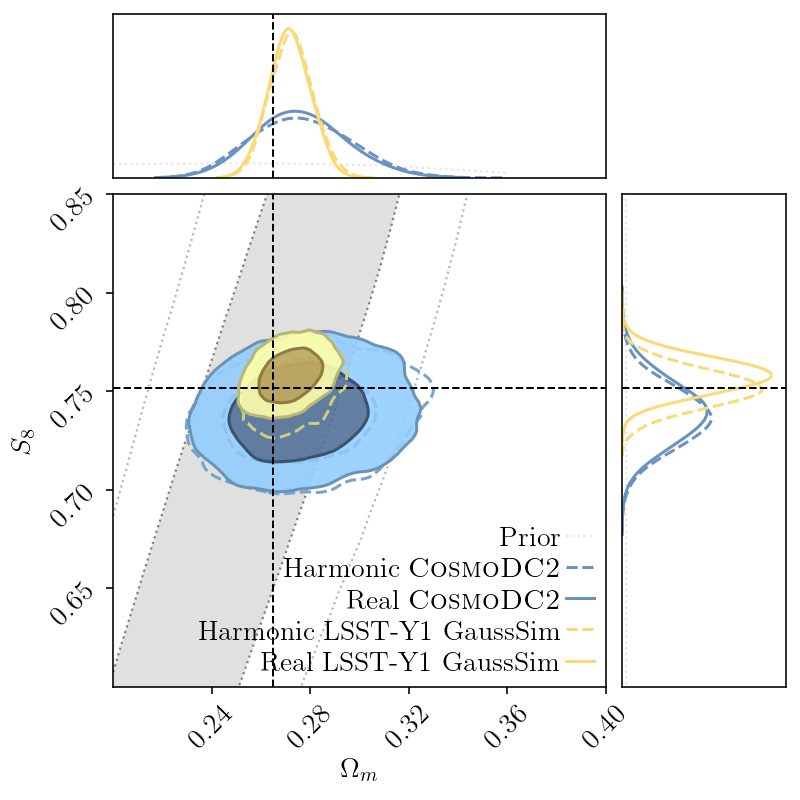

In [9]:
# FireCrown names
cosmo_parnames = [ 'COSMOLOGICAL_PARAMETERSOMEGA_M', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$\Omega_m$', '$S_8$']#'$\sigma_8$',]
cosmo_truths = [2.647887e-01, 0.7515866949]#,#8.000000e-01]

cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo1 = get_indices(chainfile_1, cosmo_parnames)
cosmo2 = get_indices(chainfile_2, cosmo_parnames)
cosmo3 = get_indices(chainfile_3, cosmo_parnames)
cosmo4 = get_indices(chainfile_4, cosmo_parnames)

c = ChainConsumer()
c.add_chain(chain_4[:,cosmo4], parameters=cosmo_names, name=name_4)
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(chain_1[burnin:,cosmo1], parameters=cosmo_names, name=name_1)
c.add_chain(chain_2[burnin:,cosmo2], parameters=cosmo_names, name=name_2)
c.add_chain(chain_3[burnin:,cosmo3], parameters=cosmo_names, name=name_3)


def call_configure(c):
    c.configure(kde=kde, shade=[True, False,True,False,True,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=["#E5E4E2",colors[1],colors[1],  colors[3], colors[3]],legend_kwargs={"fontsize": 14, 'loc':"lower right"},
            legend_color_text=False, tick_font_size=14, label_font_size=14, linewidths=[1.1, 1.5, 1.5,1.5, 1.5, 1.1, 2.5, 1], linestyles=[":","--", "-","--", "-","-", "-", "--",":"])
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot(figsize=(3.,3.), truth=cosmo_truths, extents=[(0.2, 0.4), (0.6, 0.85)])
fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_om_S8.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_om_S8.pdf'%(name_plots, burnin), bbox_inches="tight",)


# Plot bias

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $b_1$ & $b_2$ & $b_3$ & $b_4$ & $b_5$ \\ 
		\hline
		Prior & $1.24^{+0.81}_{-0.70}$ & $1.36^{+0.80}_{-0.74}$ & $1.53^{+0.78}_{-0.79}$ & $1.66^{+0.76}_{-0.79}$ & $1.80^{+0.75}_{-0.81}$ \\ 
		Harmonic $\textsc{CosmoDC2}$ & $0.916^{+0.051}_{-0.049}$ & $1.097^{+0.050}_{-0.056}$ & $1.251^{+0.056}_{-0.057}$ & $1.367^{+0.059}_{-0.060}$ & $1.624^{+0.062}_{-0.074}$ \\ 
		Real $\textsc{CosmoDC2}$ & $0.917^{+0.058}_{-0.055}$ & $1.048\pm 0.060$ & $1.270^{+0.072}_{-0.062}$ & $1.378^{+0.064}_{-0.071}$ & $1.573^{+0.078}_{-0.084}$ \\ 
		\hline
    \end{tabular}
\end{table}


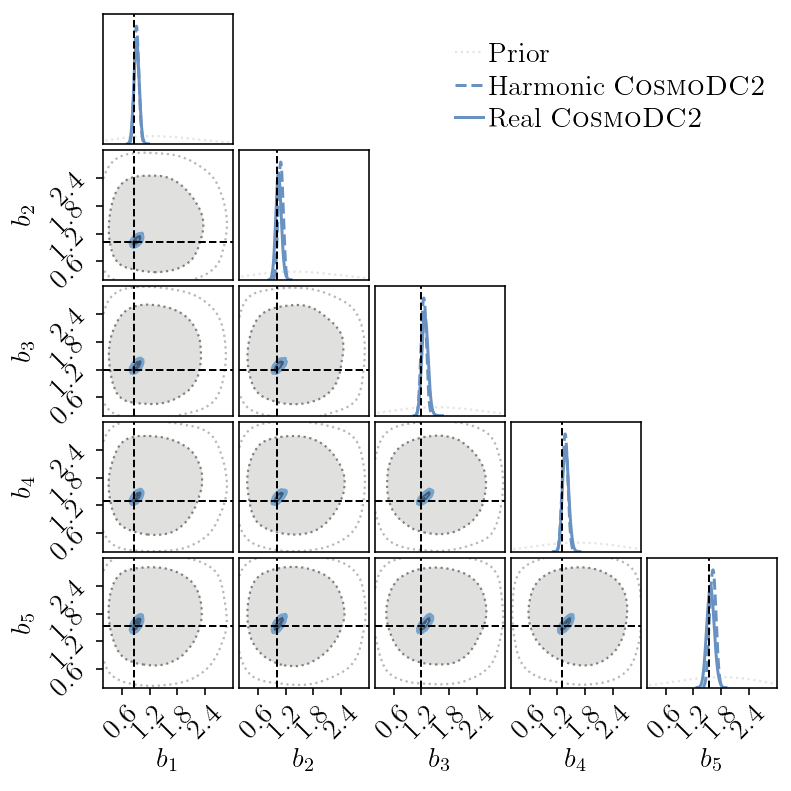

In [10]:
# FireCrown names
bias_parnames = [ 'firecrown_two_pointlens_%s_bias'%(l) for l in range(5)]
bias_names = ['$b_1$','$b_2$', '$b_3$', '$b_4$', '$b_5$']
bias_truths = [0.87, 1.02, 1.19, 1.30, 1.54]

bias0 = get_indices(chainfile_0, bias_parnames)
bias1 = get_indices(chainfile_1, bias_parnames)
bias4 = get_indices(chainfile_4, bias_parnames)

c = ChainConsumer()

c.add_chain(chain_4[:,bias4], parameters=bias_names, name=name_4)
c.add_chain(chain_0[burnin:,bias0], parameters=bias_names, name=name_0)
c.add_chain(chain_1[burnin:,bias1], parameters=bias_names, name=name_1)


def call_configure(c):
    c.configure(kde=kde, shade=[True, True,False,False,True,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9,0.9], bar_shade=False,colors=["#E5E4E2",colors[1],colors[1],  colors[3], colors[3]],legend_kwargs={"fontsize": 14, 'loc':"lower right"},
            legend_color_text=False, tick_font_size=14, label_font_size=14, linewidths=[1.1, 1.5, 1.5,1.5, 1.5, 1.1, 2.5, 1], linestyles=[":","--", "-","--", "-","-", "-", "--",":"])
    return c

c = call_configure(c)

table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot(figsize=(3.,3.), truth=bias_truths)
fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/bias_%s_%d.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/bias_%s_%d.pdf'%(name_plots, burnin), bbox_inches="tight",)


## Get table values

In [11]:
# FireCrown names
cosmo_parnames = [ 'COSMOLOGICAL_PARAMETERSOMEGA_M', 'COSMOLOGICAL_PARAMETERSS_8', 'COSMOLOGICAL_PARAMETERSSIGMA_8']
cosmo_names = ['$\Omega_m$', '$S_8$', '$\sigma_8$',]
cosmo_truths = [2.647887e-01, 0.7515866949, 8.000000e-01]


cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo1 = get_indices(chainfile_1, cosmo_parnames)
cosmo2 = get_indices(chainfile_2, cosmo_parnames)
cosmo3 = get_indices(chainfile_3, cosmo_parnames)
cosmo4 = get_indices(chainfile_4, cosmo_parnames)

c = ChainConsumer()
c.add_chain(chain_4[:,cosmo4], parameters=cosmo_names, name=name_4)
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(chain_1[burnin:,cosmo1], parameters=cosmo_names, name=name_1)
c.add_chain(chain_2[burnin:,cosmo2], parameters=cosmo_names, name=name_2)
c.add_chain(chain_3[burnin:,cosmo3], parameters=cosmo_names, name=name_3)


def call_configure(c):
    c.configure(kde=kde, shade=[True, True,False,False,True,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9,0.9], bar_shade=False,colors=["#E5E4E2",colors[1],colors[1],  colors[3], colors[3]],legend_kwargs={"fontsize": 14, 'loc':"lower right"},
            legend_color_text=False, tick_font_size=14, label_font_size=14, linewidths=[1.1, 1.5, 1.5,1.5, 1.5, 1.1, 2.5, 1], linestyles=[":","--", "-","--", "-","-", "-", "--",":"])
    return c

c = call_configure(c)


table = c.analysis.get_latex_table()
print(table)



\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccc}
        \hline
		Model & $\Omega_m$ & $S_8$ & $\sigma_8$ \\ 
		\hline
		Prior & $0.252^{+0.063}_{-0.104}$ & $0.66^{+0.26}_{-0.38}$ & $0.75^{+0.21}_{-0.31}$ \\ 
		Harmonic $\textsc{CosmoDC2}$ & $0.274^{+0.022}_{-0.020}$ & $0.737\pm 0.016$ & $0.767\pm 0.031$ \\ 
		Real $\textsc{CosmoDC2}$ & $0.274^{+0.019}_{-0.018}$ & $0.740^{+0.016}_{-0.018}$ & $0.771^{+0.031}_{-0.029}$ \\ 
		Harmonic LSST-Y1 GaussSim & $\left( 272.4^{+8.6}_{-9.2} \right) \times 10^{-3}$ & $\left( 751.1^{+10.4}_{-9.7} \right) \times 10^{-3}$ & $0.789^{+0.013}_{-0.014}$ \\ 
		Real LSST-Y1 GaussSim & $\left( 271.1^{+9.1}_{-8.1} \right) \times 10^{-3}$ & $\left( 758.2^{+9.2}_{-9.5} \right) \times 10^{-3}$ & $0.797^{+0.012}_{-0.014}$ \\ 
		\hline
    \end{tabular}
\end{table}
